In [7]:
import polars as pl 
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
import implicit # For BPR
from scipy.sparse import coo_matrix, csr_matrix
from torch.nn.utils.rnn import pad_sequence
import pyarrow
from torch.nn import functional as F
import matplotlib.pyplot as plt

## Helpers

In [2]:
train_len = 715613
val_len = 92112
test_len = 92112
total_len = train_len + val_len + test_len
assert total_len == 899837
num_users = 92112
num_items = 10546
k_vals = [10, 25, 50]
embed_dim = 64
batch_size = 128
learning_rate = 1e-3
block_size = 64
dropout = 0.5
SEED = 42
padding_idx = 0
ignore_idx = -100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


def build_results_df(model_name, k_vals, hits_at_k, precision_at_k):
    """
    Returns a DataFrame with the results of the model, given lists of k_vals, hits_at_k, and precision_at_k
    """
    return pl.DataFrame(
        {
            "model": [model_name] * len(k_vals),
            "k": k_vals,
            "hits_at_k": hits_at_k,
            "precision_at_k": precision_at_k
        }
    )

cuda


## Data Loading

In [3]:
def load_full_data():
    """
    Returns the full dataset sorted by user_id
    """
    exclude_cols = ["hours", "products", "found_funny", "hours", "text"]
    df = pl.scan_parquet("data/reviews.parquet")
    print(df.collect())

def load_train_val_test_data(): 
    """
    Returns datasets sorted by user_id with idx of their initial position in the dataset
    - X_train: All interactions except the last two per user
    - y_valid: Second to last interaction per user
    - y_test: Last interaction per user
    """
    exclude_cols = ["hours", "products", "found_funny", "hours", "text"]
    full = pl.scan_parquet("data/sorted_reviews.parquet").drop(exclude_cols).with_row_index("idx")
    users_with_less_than_2_interactions = full.group_by("mapped_user_id").agg(pl.count("mapped_product_id").alias("interaction_count"))
    users_with_less_than_2_interactions = users_with_less_than_2_interactions.filter(pl.col("interaction_count") < 5)
    
    y = full.group_by("mapped_user_id").tail(2)
    X_train = full.join(y, on="idx", how="anti") # Up to two interactions from last per user

    y_valid = y.group_by("mapped_user_id").head(1) # 1 interaction from last per user
    y_test = y.group_by("mapped_user_id").tail(1) # Last interaction per user

    assert total_len == len(full.collect())
    assert train_len == len(X_train.collect())
    assert val_len == len(y_valid.collect())
    assert test_len == len(y_test.collect())

    return X_train, y_valid, y_test

def format_train_eval_data(df, cols_to_keep=["idx", "user_id", "product_id"]): 
    """
    Formats the data to have the columns: idx, user_id, product_id
    """
    exclude_cols = ["review_date", "mapped_user_id", "mapped_product_id"]
    return (
        df
        .with_columns(
            pl.col("mapped_user_id").alias("user_id"),
            pl.col("mapped_product_id").alias("product_id"),
        )
        .drop(exclude_cols)
        .select(cols_to_keep)
    )

def get_clean_train_valid_eval(): 
    """ 
    Returns the datasets formatted for training and evaluation
    - X_train: All interactions except the last two per user
    - y_valid: Second to last interaction per user
    - y_test: Last interaction per user
    """
    X_train, y_valid, y_test = load_train_val_test_data()
    X_train = format_train_eval_data(X_train)
    y_valid = format_train_eval_data(y_valid)
    y_test = format_train_eval_data(y_test)
    assert total_len == len(X_train.collect()) + len(y_valid.collect()) + len(y_test.collect())
    return X_train, y_valid, y_test

def join_x_y(X, y):
    """
    Joins the training and validation datasets on each user 
    - X_test: All interactions except the last one per user
    """
    X_join = pl.concat([X, y], how="vertical").sort("idx")
    assert len(X_join.collect()) == len(X.collect()) + len(y.collect())
    return X_join

## Baseline Experiments

### Experiment 1: Popularity

In [6]:
def get_k_most_popular_items(X, k=50): 
    """
    Returns the k most popular items in X
    """
    popular_items = (
        X
        .group_by("product_id")
        .agg(pl.count("product_id").alias("count"))
        .sort("count", descending=True)
        .head(k)
    )
    return popular_items
    
def predict_based_on_item_popularity(X_train, y_valid, k=50): 
    """
    Predicts the most popular items for each user
    """
    X_test = join_x_y(X_train, y_valid)
    top_k_items = get_k_most_popular_items(
        X_test,
        k)
    assert len(top_k_items.collect()) == k
    return top_k_items


def popularity_baseline(k_vals = k_vals):
    X_train, y_valid, y_test = get_clean_train_valid_eval()
    
    hits_at_k = []
    precision_at_k = []
    ndcg_at_k = []

    for k in k_vals:
        y_pred = predict_based_on_item_popularity(X_train, y_valid, k = k)
        hits = len(y_pred.join(y_test, on=["product_id"]).collect())

        num_predictions = len(y_pred.collect())
        number_of_users = len(y_test.collect()) 

        hits_at_k.append(hits / number_of_users)

        # Number of hits divided by number of predictions
        precision_at_k.append(hits / k / number_of_users)

    results = build_results_df("popularity", k_vals, hits_at_k, precision_at_k)

    return results

In [7]:
popularity_baseline()

model,k,hits_at_k,precision_at_k
str,i64,f64,f64
"""popularity""",10,0.038866,0.003887
"""popularity""",25,0.079729,0.003189
"""popularity""",50,0.125228,0.002505


### Experiment 2: Markov Chain 

In [8]:
def get_transition_matrix_from_markov_chain(X):
    """
    Builds a transition matrix from transition counts
    OLD Method, stopped using it since pivots cannot be Lazy
    """
    return (
            X.collect()
            .pivot(
                on="prev_product_id",
                index="product_id",
                values="transitions",
                aggregate_function="sum"
            )
            .fill_null(0)
            .rename({"product_id": "next_product_id"})
            .with_columns(pl.all().exclude("next_product_id") / pl.all().sum())
            .lazy()
        )

def get_matrix_shifted_by_3(X):
    """
    Returns matrix shifted by 3
    """
    return (
        X.with_columns([
            pl.col("product_id").shift(1).alias("prev_1_product_id"),
            pl.col("user_id").shift(1).alias("prev_1_user_id"),
            pl.col("product_id").shift(2).alias("prev_2_product_id"),
            pl.col("user_id").shift(2).alias("prev_2_user_id"),
            pl.col("product_id").shift(3).alias("prev_3_product_id"),
            pl.col("user_id").shift(3).alias("prev_3_user_id"),
        ])
        .filter(pl.col("prev_3_product_id").is_not_null())
        .filter(pl.col("user_id") == pl.col("prev_3_user_id"))
    )

def get_previous_n_transitions(X, n=1):
    """
    Returns the previous n transitions for each user weighted by how far back they are
    """
    prev_column = f"prev_{n}_product_id"
    return (
        X
        .group_by([prev_column, "product_id"])
        .len().rename({"len": "transitions"})
        .with_columns([pl.col("transitions") / n])
        .rename({prev_column: "prev_product_id"})
    )

def get_3rd_order_markov_chain(X):
    """
    Returns the transition probabilities for a 3rd order Markov chain
    """
    X_shifted = get_matrix_shifted_by_3(X)
    
    n_1_transition_counts = get_previous_n_transitions(X_shifted, n=1)
    n_2_transition_counts = get_previous_n_transitions(X_shifted, n=2)
    n_3_transition_counts = get_previous_n_transitions(X_shifted, n=3)

    transition_counts = pl.concat([n_1_transition_counts, n_2_transition_counts, n_3_transition_counts])
    
    transition_probs = (
        transition_counts
        .with_columns(pl.col("transitions") / pl.col("transitions").sum().over("prev_product_id"))
        .rename({
            "transitions": "probability",
            "product_id": "next_product_id",
            "prev_product_id": "product_id",
            })
    )
    
    return transition_probs

def predict_based_on_markov_chain(y, transition_matrix, k=50):
    """
    Predicts the next k items based on the transition matrix
    """
    y_pred =  (
        y
        .drop("idx")
        .join(transition_matrix, on="product_id", how="left")
        .group_by("user_id")
        .agg(
            [
                pl.struct(["next_product_id", "probability"])
                .sort_by("probability", descending=True)
                .slice(0, k)
                .alias("top_predictions")
            ]
        )
        .explode("top_predictions")
        .select(
            "user_id",
            pl.col("top_predictions").struct.field("next_product_id").alias("product_id"),
            pl.col("top_predictions").struct.field("probability").alias("probability"),
        )
    )
    return y_pred

def markov_chain_experiment(k_vals = k_vals):
    X_train, y_valid, y_test = get_clean_train_valid_eval()
    X_test = join_x_y(X_train, y_valid)

    transition_matrix = get_3rd_order_markov_chain(X_test)
    hits_at_k = []
    precision_at_k = []

    for k in k_vals:
        y_pred = predict_based_on_markov_chain(y_valid, transition_matrix, k = k)
        hits = len(y_pred.join(y_test, on=["user_id", "product_id"]).collect())

        num_predictions = len(y_pred.collect())
        number_of_users = len(y_test.collect()) 

        hits_at_k.append(hits / number_of_users)
        precision_at_k.append(hits / k / number_of_users)

    results = build_results_df("Markov Chain", k_vals=k_vals, hits_at_k=hits_at_k, precision_at_k=precision_at_k)

    return results

In [ ]:
markov_chain_experiment()

## Transformer Experiments

### Experiment 3: Decoder

#### Dataset

In [4]:
def get_data(block_size=block_size):
    X_train, y_train, y_test = get_clean_train_valid_eval()
    train = join_x_y(X_train, y_train) 
    test = join_x_y(train, y_test)
    column_ordering = X_train.collect_schema().names()
    
    assert len(train.collect()) + len(y_test.collect()) == total_len
    assert len(test.collect()) == total_len
    
    train = train.group_by("user_id").tail(block_size).select(column_ordering)
    test = test.group_by("user_id").tail(block_size).select(column_ordering)

    return train, test

class SequentialRecommenderDataset(Dataset):
    def __init__(self, data, block_size=block_size):
        self.block_size = block_size
        self.num_users = data.group_by("user_id").len().collect().shape[0]

        samples = (
            data
            .group_by("user_id")
            .agg(pl.col("product_id"))
            .collect()
            .to_dict()
        )
        self.samples = {}
        self.user_ids = []
        
        for i, (u_id, p_ids) in enumerate(zip(samples["user_id"], samples["product_id"])):
            self.samples[int(u_id)] = torch.tensor(p_ids, dtype=torch.long)
            self.user_ids.append(int(u_id))
            
        assert len(self.user_ids) == self.num_users


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Returns the sequence of items and sequence of items shifted by 1 to predict
        item_sequence = self.samples[self.user_ids[idx]]
        x = item_sequence[:-1]
        y = item_sequence[1:]
        return x, y

def padding_collate(batch):
    sequences, labels = zip(*batch)
    
    last_items_idx = torch.tensor([len(seq) - 1 for seq in sequences], dtype=int)
    
    # THIS IS TERRIBLE, THIS WILL LIKELY CAUSE AN ERORR LATER WHEN I FORGET ABOUT SCOPE
    max_len = block_size

    padded_sequences = torch.stack([
        torch.nn.functional.pad(seq, (0, max_len - seq.size(0)), "constant", padding_idx)
        for seq in sequences
    ])

    padded_labels = torch.stack([
        torch.nn.functional.pad(label, (0, max_len - label.size(0)), "constant", ignore_idx)
        for label in labels
    ])

    # # Find pred indices 
    # mask = (padded_labels != ignore_idx)  # (B, T)

    # pred_idx = mask.long().cumsum(dim=1) - 1
    # pred_idx = pred_idx.gather(1, mask.sum(dim=1, keepdim=True) - 1).squeeze(1)
    # pred_idx[mask.sum(dim=1) == 0] = -1

    return padded_sequences, padded_labels, last_items_idx

def get_transformer_datasets():
    train, test = get_data()
    train_dataset = SequentialRecommenderDataset(train)
    test_dataset = SequentialRecommenderDataset(test)
    return train_dataset, test_dataset

#### Transformer Classes
Transformer classes based off work from Matthew O'Malley-Nichols

In [5]:
class SelfAttentionBase(nn.Module):
    def __init__(self, embed_dim, block_size, head_dim, autoregression, dropout):
        super().__init__()
        self.embed_dim = embed_dim 
        self.head_dim = head_dim
        self.block_size = block_size
        self.autoregression = autoregression

        # Channels x Head size
        self.query_linear = nn.Linear(self.embed_dim, self.head_dim, bias=False)
        self.key_linear = nn.Linear(self.embed_dim, self.head_dim, bias=False)
        self.value_linear = nn.Linear(self.embed_dim, self.head_dim, bias=False)

        if self.autoregression:
            self.register_buffer("mask", torch.tril(torch.ones(self.block_size, self.block_size)))
        self.dropout = nn.Dropout(dropout)

    def get_shape(self, x):
        B, T, C = x.shape
        assert C == self.embed_dim
        return B, T, C

    def project_linear_components(self, x):
        # Get the linearly projected queries, keys, and values
        query = self.query_linear(x)
        key = self.key_linear(x)
        value = self.value_linear(x)
        return query, key, value

    def mask_causal_logits(self, logits, T):
        # Mask out future tokens if decoder
        if self.autoregression:
            logits = logits.masked_fill(self.mask == 0, float("-inf"))
        return logits

    def compute_attention(self, logits, value):
        weights = F.softmax(logits, dim=-1)
        regularized_weights = self.dropout(weights)
        attention = torch.einsum("btt,btc->btc", regularized_weights, value)
        return attention, weights


class SelfAttentionHead(SelfAttentionBase):
    # Single head of attention based off "Let's build GPT: from scratch, in code, spelled out" by Andrej Karpathy
    # and the "Attention is All You Need" paper
    def __init__(self, embed_dim, block_size, head_dim, autoregression, dropout):
        super().__init__(embed_dim=embed_dim, 
                         block_size=block_size, 
                         head_dim=head_dim, 
                         autoregression=autoregression, 
                         dropout=dropout)

    def forward(self, x, attention_mask):
        # Forward pass for basic self attention
        B, T, C = self.get_shape(x)
        q, k, v = self.project_linear_components(x)

        # Compute attention weights
        logits = torch.einsum("btc,bTc->bTt", q, k) # B x T x C @ B x T x C -> B x T x T
        logits = logits / (C ** 0.5) # Divide by sqrt(d_k) to prevent peaky softmax

        logits = logits.masked_fill(attention_mask, float("-inf"))
        logits = self.mask_causal_logits(logits, T)
        attention, weights = self.compute_attention(logits, v)

        return attention, weights 
        
class MultiHeadAttention(nn.Module):
    # Multiple heads of attention based off "Let's build GPT: from scratch, in code, spelled out" by Andrej Karpathy
    # and the "Attention is All You Need" paper
    def __init__(self, num_heads, embed_dim, block_size, autoregression, attention, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0
        self._init_heads(num_heads, embed_dim, block_size, autoregression, attention, dropout)

        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
    
    def _init_heads(self, num_heads, embed_dim, block_size, autoregression, attention, dropout):
        head_dim = embed_dim // num_heads
        params = {
            "embed_dim": embed_dim,
            "block_size": block_size,
            "head_dim": head_dim,
            "autoregression": autoregression,
            "dropout": dropout
            }
        self.heads = nn.ModuleList([SelfAttentionHead(**params) for _ in range(num_heads)])

    def forward(self, x, attention_mask):
        # Multihead attention based off "Attention is All You Need" paper
        attention_maps = []
        attentions = []
        for head in self.heads:
            attention_output, attention_map = head(x, attention_mask)
            attention_maps.append(attention_map)
            attentions.append(attention_output)

        concatenated_attention = torch.cat(attentions, dim=-1)
        concatenated_attention = self.dropout(self.proj(concatenated_attention))
        return concatenated_attention, attention_maps

class FeedForward(nn.Module):
    # Feed forward network based off "Let's build GPT: from scratch, in code, spelled out" by Andrej Karpathy
    def __init__(self, embed_dim, hidden_dim, dropout=0.0):
        super().__init__()

        self.ff_net = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.ff_net(x)

class TransformerBlock(nn.Module):
    # Single transformer block based off "Attention is All You Need" paper
    def __init__(self, embed_dim, num_heads, block_size, hidden_dim, autoregression, attention, dropout=0.0):
        super().__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, 
                                            embed_dim=embed_dim, 
                                            block_size=block_size, 
                                            autoregression=autoregression, 
                                            attention=attention, 
                                            dropout=dropout)

        self.feed_forward = FeedForward(embed_dim=embed_dim, 
                                        hidden_dim=hidden_dim, 
                                        dropout=dropout)

        self.layer_norm1 = nn.LayerNorm(embed_dim) # Pre-normalization
        self.layer_norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, attention_mask):
        # Residual connection around each sub-block
        attentions, attention_maps = self.attention(self.layer_norm1(x), attention_mask)
        with torch.no_grad(): # Discard gradients for the attention maps
            attention_maps = [attn_map.detach() for attn_map in attention_maps]
        x = x + attentions
        x = x + self.feed_forward(self.layer_norm2(x))
        return x, attention_maps

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, block_size, embed_dim):
        super().__init__()
        self.positional_embedding = nn.Embedding(block_size, embed_dim)

    def forward(self, x):
        B, T = x.shape
        return self.positional_embedding(torch.arange(T, device=x.device))

class TransformerBase(nn.Module):
    def __init__(self, vocab_size, embed_dim, block_size, num_heads, num_layers, hidden_dim, autoregression, attention="basic", position_encoding="learned", dropout=0.0):
        super().__init__()
        self.position_encoding = LearnedPositionalEncoding(block_size, embed_dim)
        self.token_embedding_table = nn.Embedding(vocab_size+1, embed_dim, padding_idx=0)
        self.block_size = block_size

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, block_size, hidden_dim, autoregression, attention, dropout) 
            for _ in range(num_layers)
            ])
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.Linear):
            # nn.init.kaiming_normal_(module.weight)
            # Normal distribution reduces train perplexity to be within range, at cost of test perplexity
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)


    def embed(self, x):
        # Return the embeddings for the input sequence
        B, T = x.shape
        token_embeddings = self.token_embedding_table(x)
        if not self.position_encoding:
            return token_embeddings
        pos_embeddings = self.position_encoding(x)
        return token_embeddings + pos_embeddings

class Decoder(TransformerBase):
    def __init__(self, vocab_size=num_items, embed_dim=embed_dim, block_size=block_size, 
                 num_heads=2, num_layers=4, hidden_dim=embed_dim*4, 
                 attention="basic", position_encoding="learned", dropout=0.0, neg_ce_loss=False):
        super().__init__(vocab_size=vocab_size,
                         embed_dim=embed_dim,
                         block_size=block_size,
                         num_heads=num_heads,
                         num_layers=num_layers,
                         hidden_dim=hidden_dim,
                         autoregression=True,
                         position_encoding=position_encoding,
                         attention=attention,
                         dropout=dropout)
        self.neg_ce_loss = neg_ce_loss
        self.rec_head = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, y=None):
        attention_mask = x == 0 # B x T  
        attention_mask = attention_mask.unsqueeze(1)  # Shape: (B, 1, T)
        attention_mask = attention_mask.expand(-1, self.block_size, -1)  # Shape: (B, T, T)

        x = self.embed(x)
        
        attention_maps = []
        for block in self.blocks:
            x, maps = block(x, attention_mask)
            attention_maps.extend(maps)

        x = self.layer_norm(x)
        logits = self.rec_head(x) # B x T x V

        cross_entropy_loss = None
        if y is not None:
            logits_flat = logits.view(-1, logits.size(-1))
            y_flat = y.view(-1)
            cross_entropy_loss = F.cross_entropy(logits_flat, y_flat, ignore_index=ignore_idx)
            if self.neg_ce_loss:
                with torch.no_grad():
                    B = x.size(0)
                    for i in range(B):
                        neg_mask = torch.arange(B) != i
                        neg_logits = logits[neg_mask]
                        neg_loss = -torch.mean(torch.log_softmax(neg_logits.view(-1, neg_logits.size(-1)), dim=-1).sum(dim=-1) + 1e-12)
                        cross_entropy_loss += neg_loss

        return logits, cross_entropy_loss, attention_maps

    def get_batch_metrics_at_k(self, logits, Y, last_items_idx, k):
        with torch.no_grad():
            row_indices = torch.arange(batch_size)[:len(Y)]
            last_targets = Y[row_indices, last_items_idx] 
            
            pred = logits[row_indices, last_items_idx, :]

            prob = F.softmax(pred, dim=-1)
            
            top_k_values, top_k_indices = torch.topk(prob, k=k, dim=-1)
            
            hits = (last_targets.unsqueeze(1) == top_k_indices)  # Shape: [B, k]
            hit_count = hits.any(dim=1).sum().item()
            hit_at_k = hit_count / batch_size

            dcg = (hits.float() / torch.log2(torch.arange(2, k + 2, device=logits.device).float())).sum(dim=1)
            ideal_relevance = torch.ones(len(row_indices), k, device=logits.device)
            idcg = (ideal_relevance / torch.log2(torch.arange(2, k + 2, device=logits.device).float())).sum(dim=1)
            
            ndcg = (dcg / idcg)
            ndcg[torch.isnan(ndcg)] = 0.0
            ndcg = ndcg.mean().item()
        
            return hit_at_k, ndcg

#### Transformer Training

In [11]:
def train_transformer(num_epochs=50, batch_size=32, num_items=num_items, learning_rate=learning_rate, k_vals=k_vals, model_name="decoder_ce"):
    # Overfit quickly with num_heads =2 and num_layers =4 w/ 1e-3 learning rate
    train_dataset, test_dataset = get_transformer_datasets()
    del test_dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=padding_collate)
    #test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=padding_collate)
    model = Decoder(dropout=dropout, neg_ce_loss=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(device)
    
    model.train()
    max_hit = -np.inf
    patience = 3
    for epoch in range(num_epochs):
        total_hits = 0
        print(epoch)
        for batch, (X, Y, last_items_idx) in enumerate(train_loader):
            X = X.to(device)
            Y = Y.to(device)  

            optimizer.zero_grad()
            logits, loss, _ = model(X, Y)
            
            loss.backward()
            optimizer.step()

            if batch % 100 == 0:
                pass
                #last_items_idx.to(device)
                #hit, ncdg = model.get_batch_metrics_at_k(logits, Y, last_items_idx, 50)
                #total_hits += hit
                # print(f"Epoch {epoch}, Batch {batch}, Loss {loss}")
                # print(f"Epoch {epoch}, Batch {batch}, hit@k {hit, ncdg}")
        if total_hits < max_hit:
            patience -= 1 
        else:
            min_hit = total_hits
        if patience <= 0:
            break

    torch.save(model.state_dict(), f"./models/{model_name}_{epoch}.pth")

train_transformer()

#### Transformer Evaluation

In [29]:
def transformer_eval(model_str="decoder_bce_50_5", k_vals=k_vals, batch_size=batch_size, num_items=num_items):
    train_dataset, test_dataset = get_transformer_datasets()
    del train_dataset
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=padding_collate)

    state_dict_path = f"./models/{model_str}.pth"
    model = Decoder(dropout=dropout)
    model.load_state_dict(torch.load(state_dict_path))
    model = model.to(device)

    model.eval()
    results = {}

    hits_at_k = [0.0 for k in k_vals]
    ncdg_at_k = [0.0 for k in k_vals]

    num_batches = 0 
    for batch, (X, Y, last_items_idx) in enumerate(test_loader):
        num_batches += 1
        X = X.to(device)
        Y = Y.to(device)  
        last_items_idx = last_items_idx.to(device)
        logits, _, _ = model(X)

        for i, k in enumerate(k_vals):
            hit, ncdg = model.get_batch_metrics_at_k(logits, Y, last_items_idx, k)
            hits_at_k[i] += hit
            ncdg_at_k[i] += ncdg

    ncdg_at_k = np.array(ncdg_at_k) / num_batches 
    hits_at_k = np.array(hits_at_k) / num_batches 

    return pl.DataFrame(
        {
            "model": [f"{model_str}"] * len(k_vals),
            "k": k_vals,
            "hits_at_k": hits_at_k,
            "ncdg_at_k": ncdg_at_k
        }
    )
transformer_eval()

/tmp/ipykernel_3961/1665259353.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_dict_path))


model,k,hits_at_k,ncdg_at_k
str,i64,f64,f64
"""decoder_bce_50_5""",10,0.07615,0.008624
"""decoder_bce_50_5""",25,0.14069,0.00674
"""decoder_bce_50_5""",50,0.21326,0.005329


## Evaluation

In [42]:
def concat_results():
    bert4rec = pl.read_csv("./results/bert4rec.csv").drop("precision_at_k")
    decoder_ce_15 = pl.read_csv("./results/decoder_ce_15.csv").drop("ncdg_at_k").with_columns(pl.col("model").replace("decoder_ce_50_15", "D-CE"))
    decoder_bce_15 = pl.read_csv("./results/decoder_bce_15.csv").drop("ncdg_at_k").with_columns(pl.col("model").replace("decoder_bce_50_15", "D-CCE"))
    popularity = pl.read_csv("./results/popularity_baseline.csv").drop("precision_at_k").with_columns(pl.col("model").replace("popularity", "PopRec"))
    markov_chain = pl.read_csv("./results/markov_chain.csv").drop("precision_at_k")
    results = pl.concat([bert4rec, decoder_ce_15, decoder_bce_15, popularity, markov_chain]).filter(pl.col("k") > 5)
    # Round all to 4 decimal places 
    results = (
        results
        .with_columns(
            pl.col("hits_at_k").round(4),
        )
        .pivot(on="k", index="model", values="hits_at_k")
        .sort("50", descending=True)
    )
    return results

concat_results().write_csv("./results/total_results.csv")

In [47]:
def print_hyperparameters():
    hp = pl.DataFrame(
        {
            "Hyperparameter": ["Batch Size",
                               "Block Size", 
                               "Dropout",
                               "Embedding Dim", 
                               "Epochs",
                               "Hidden Dim", 
                               "Learning Rate", ],
            "Bert4Rec": [256, 50, 0.5, 64, 5, 64, 0.001], 
            "D-CE": [128, 64, 0.5, 64, 15, 256, 0.001],
            "D-CCE": [32, 64, 0.5, 64, 15, 256, 0.001],
        }, strict=False
    )
    return hp
print_hyperparameters().write_csv("./results/hyperparameters.csv")

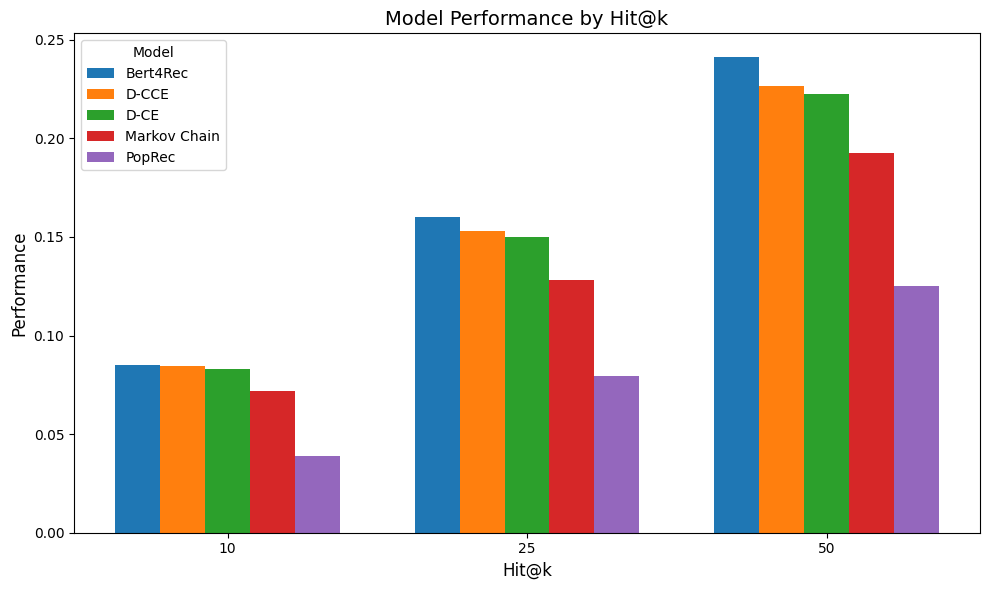

In [10]:
def visualize_hits_at_k():
    data = pl.read_csv("./results/total_results.csv")
    models = data["model"].to_list()
    categories = ["10", "25", "50"]
    values = data[categories].to_numpy()
    
    x = np.arange(len(categories))
    width = 0.15
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, (model, values_row) in enumerate(zip(models, values)):
        ax.bar(x + i * width, values_row, width, label=model)
    
    ax.set_xlabel('Hit@k', fontsize=12)
    ax.set_ylabel('Performance', fontsize=12)
    ax.set_title('Model Performance by Hit@k', fontsize=14)
    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(categories)
    ax.legend(title="Model")
    
    plt.tight_layout()
    plt.savefig("./results/hits_at_k.png")
    
visualize_hits_at_k()